In [25]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pickle

## Helper classes

In [2]:
class AnsatzGenerator:
    def __init__(self, num_qubits, hamiltonian):
        self.num_qubits = num_qubits
        self.hamiltonian = hamiltonian
        self.num_params_groundstate = 4*num_qubits
        self.num_params_excited = 4*(num_qubits-1)*2

    def _ctrl_ansatz_gates(self, params):
        for i in range(self.num_qubits-1):
            qml.CRY(params[i], wires=[0, i+1])
            qml.CRZ(params[self.num_qubits - 1 + i], wires=[0, i+1])

        for i in range(1, self.num_qubits - 1):
            qml.Toffoli(wires=[0,i, i+1])

        for i in range(self.num_qubits-1):
            qml.CRY(params[2*(self.num_qubits - 1) + i], wires=[0, i+1])
            qml.CRZ(params[3*(self.num_qubits - 1) + i], wires=[0, i+1])

    def _ansatz_gates(self, params):
        """Define the gates for the hardware efficient ansatz"""
        for i in range(self.num_qubits):
            qml.RY(params[i], wires=i)
        for i in range(self.num_qubits):
            qml.RZ(params[self.num_qubits + i], wires=i)
        for i in range(self.num_qubits-1):
            qml.CNOT(wires=[i, i+1])      
        for i in range(self.num_qubits):
            qml.RY(params[2*self.num_qubits + i], wires=i)
        for i in range(self.num_qubits):
            qml.RZ(params[3*self.num_qubits +i], wires=i)

    def ansatz_groundstate(self, params):
        """Define the ansatz to compute the ground state"""
        self._ansatz_gates(params)  
        return qml.expval(self.hamiltonian)

    def setGroundStateResultParams(self, result_params):
        self.result_params = result_params

    def ansatz_excited(self, params):
        """Define the ansatz to compute the excited state"""
        qml.adjoint(self._ansatz_gates)(self.result_params) 
    
        qml.PauliX(wires=0)
    
        self._ctrl_ansatz_gates(params[0:int(self.num_params_excited/2)])

        for i in range(1, self.num_qubits):
            qml.PauliX(wires=i)

        qml.MultiControlledX(control_wires=range(1, self.num_qubits), wires=0)

        for i in range(self.num_qubits):
            qml.PauliX(wires=i)

        self._ctrl_ansatz_gates(params[int(self.num_params_excited/2):])
        self._ansatz_gates(self.result_params)
        return qml.expval(self.hamiltonian)

In [3]:
class VQE:
    def __init__(self, num_params, ansatz):
        self.max_iterations = 1000
        self.conv_tol = 1e-06
        self.opt = qml.QNGOptimizer(0.01)
        self.num_params = num_params
        self.ansatz = ansatz

    def run(self):
        """Run the VQE. 
        Return the optimized parameters and the vector of energies that is computed during the optimization. 
        The last item in the vector is the lowest energy.
        """
        theta = np.random.random(self.num_params)
        energy = [self.ansatz(theta)]

        angle = [theta]

        for n in range(self.max_iterations):
            theta, prev_cost = self.opt.step_and_cost(self.ansatz, theta)
            energy.append(self.ansatz(theta))
            angle.append(theta)
            conv = np.abs(energy[-1] - prev_cost)
            if conv <= self.conv_tol:
                break
        return angle[-1], energy

# Simulations for hydrogen

In [6]:
dataset = qml.data.load("qchem", molname="H2", bondlength=0.742, basis="STO-3G",
                        attributes=["fci_spectrum", "hamiltonian"])

In [8]:
np.sort(dataset[0].fci_spectrum)

tensor([-1.13726332, -0.53892489, -0.53892489, -0.53320939, -0.53320939,
        -0.53320939, -0.44757206], requires_grad=True)

In [9]:
# print the Hamiltonian and compute the eigenvalues classically
print(dataset[0].hamiltonian)
matrixH = qml.matrix(dataset[0].hamiltonian)
eigenvalues, eigenvectors = np.linalg.eig(matrixH)
print(np.sort(eigenvalues))

  (-0.22250914236600539) [Z2]
+ (-0.22250914236600539) [Z3]
+ (-0.09963387941370971) [I0]
+ (0.17110545123720225) [Z1]
+ (0.17110545123720233) [Z0]
+ (0.12051027989546245) [Z0 Z2]
+ (0.12051027989546245) [Z1 Z3]
+ (0.16584090244119712) [Z0 Z3]
+ (0.16584090244119712) [Z1 Z2]
+ (0.16859349595532533) [Z0 Z1]
+ (0.1743207725924201) [Z2 Z3]
+ (-0.04533062254573469) [Y0 Y1 X2 X3]
+ (-0.04533062254573469) [X0 X1 Y2 Y3]
+ (0.04533062254573469) [Y0 X1 X2 Y3]
+ (0.04533062254573469) [X0 Y1 Y2 X3]
[-1.13726332+0.j -0.53892489+0.j -0.53892489+0.j -0.53320939+0.j
 -0.53320939+0.j -0.53320939+0.j -0.44757206+0.j -0.44757206+0.j
 -0.17056441+0.j  0.23684975+0.j  0.23684975+0.j  0.35111168+0.j
  0.35111168+0.j  0.47841937+0.j  0.71317537+0.j  0.91879014+0.j]


In [12]:
H = dataset[0].hamiltonian
num_qubits = 4

dev = qml.device('default.qubit', wires=num_qubits)
ansatzGenerator = AnsatzGenerator(num_qubits, H)

ansatz_groundstate = qml.QNode(ansatzGenerator.ansatz_groundstate, dev)
vqe = VQE(ansatzGenerator.num_params_groundstate, ansatz_groundstate)
params_groundstate, energies_ground = vqe.run()

ansatzGenerator.setGroundStateResultParams(params_groundstate)
ansatz_excited = qml.QNode(ansatzGenerator.ansatz_excited, dev)
vqe = VQE(ansatzGenerator.num_params_excited, ansatz_excited)
params_excited, energies_excited = vqe.run()

In [14]:
energies_ground[-1]

tensor(-1.12200976, requires_grad=True)

In [15]:
energies_excited[-1]

tensor(-0.53801234, requires_grad=True)

In [26]:
with open('energies_ground_H2_QNG.pickle', 'wb') as handle:
    pickle.dump(energies_ground, handle)
with open('energies_excited_H2_QNG.pickle', 'wb') as handle:
    pickle.dump(energies_excited, handle)
with open('params_ground_H2_QNG.pickle', 'wb') as handle:
    pickle.dump(params_groundstate, handle)
with open('params_excited_H2_QNG.pickle', 'wb') as handle:
    pickle.dump(params_excited, handle)

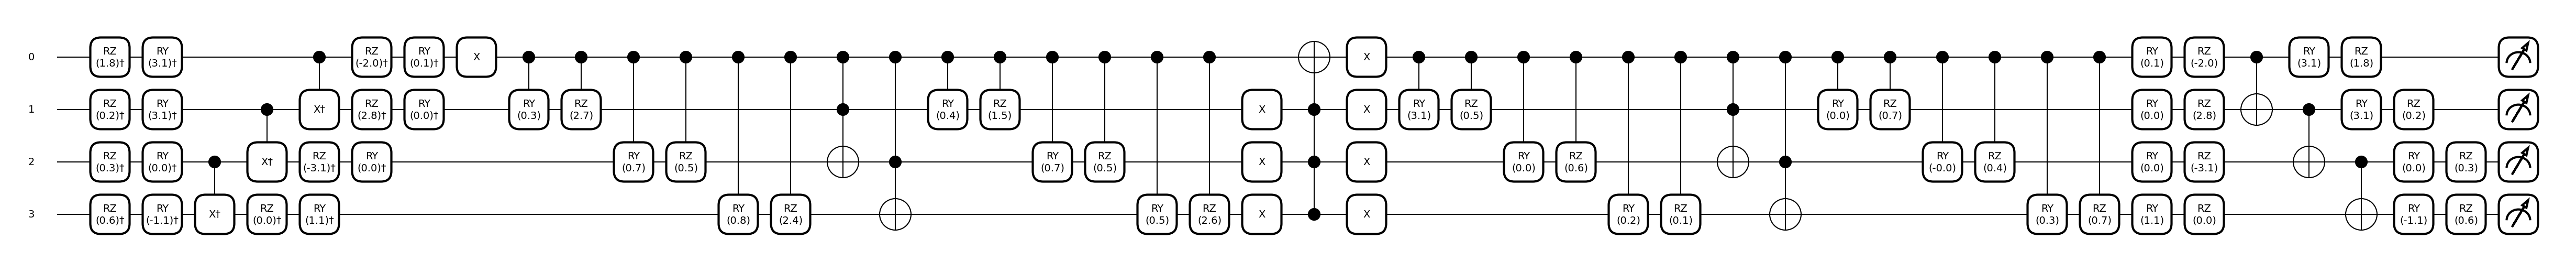

In [18]:
fig, ax = qml.draw_mpl(ansatz_excited, decimals=1)(params_excited)

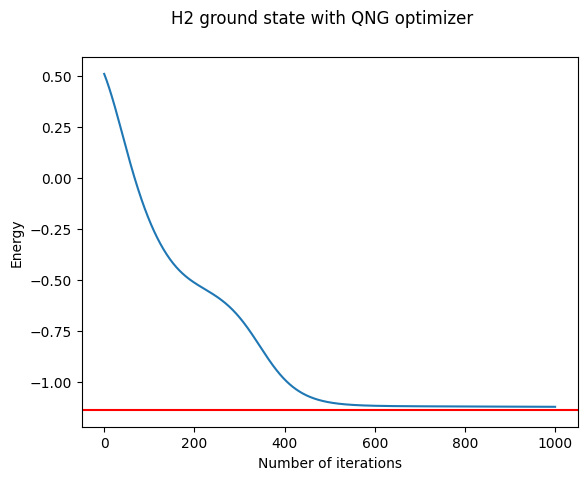

<Figure size 640x480 with 0 Axes>

In [27]:
ground = np.sort(dataset[0].fci_spectrum)[0]
plt.axhline(y=ground, color='r', linestyle='-')
plt.plot(range(len(energies_ground)), energies_ground)
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.suptitle("H2 ground state with QNG optimizer")
plt.show()
plt.savefig("H2_ground_QNG.png")

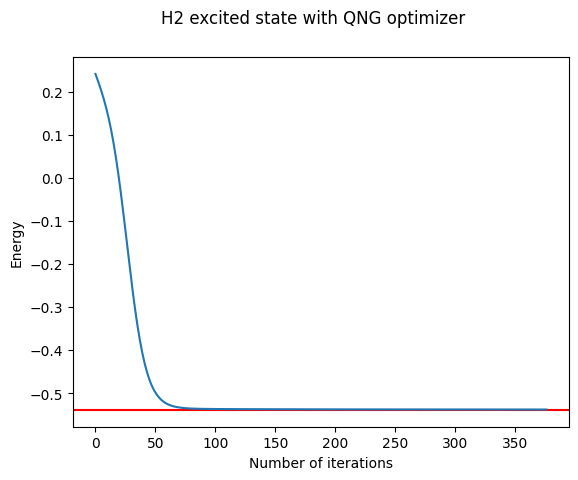

<Figure size 640x480 with 0 Axes>

In [28]:
excited = np.sort(dataset[0].fci_spectrum)[1]
plt.axhline(y=excited, color='r', linestyle='-')
plt.plot(range(len(energies_excited)), energies_excited)
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.suptitle("H2 excited state with QNG optimizer")
plt.show()
plt.savefig("H2_excited_QNG.png")